In [1]:
# Creating my own neural network... from SCRATCH!

In [2]:
import cupy as np # Using cupy for GPU acceleration, could also use numpy
import matplotlib.pyplot as plt
import pandas as pd
# nothing else needed for creating the network

In [3]:
data = pd.read_csv("diabetes.csv") # Load the dataset
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
X_train = np.array(data.iloc[:708, 0:8].values.tolist())

In [5]:
Y_train = np.array(data.iloc[:708, -1])
Y_train = Y_train.reshape(1, -1)


In [6]:
n = [8,32, 16, 8, 1] # Number of nodes in different layers of the network
L = 4

In [7]:
# initialising weights and biases
def initialize_weights():
    global W1, W2, W3, W4, b1, b2, b3, b4
    global v_dW1, v_dW2, v_dW3, v_dW4, v_db1, v_db2, v_db3, v_db4
    np.random.seed(42)
    W1 = np.random.randn(n[1], n[0])* np.sqrt(2.0/n[0])
    W2 = np.random.randn(n[2], n[1])* np.sqrt(2.0/n[1])
    W3 = np.random.randn(n[3], n[2])* np.sqrt(2.0/n[2])
    W4 = np.random.randn(n[4], n[3])* np.sqrt(1.0/n[3])
    b1 = np.random.randn(n[1], 1)
    b2 = np.random.randn(n[2], 1)
    b3 = np.random.randn(n[3], 1)
    b4 = np.random.randn(n[4], 1)


    v_dW1 = np.zeros_like(W1)
    v_db1 = np.zeros_like(b1)
    v_dW2 = np.zeros_like(W2)
    v_db2 = np.zeros_like(b2)
    v_dW3 = np.zeros_like(W3)
    v_db3 = np.zeros_like(b3)
    v_dW4 = np.zeros_like(W4)
    v_db4 = np.zeros_like(b4)


In [8]:
def scaling_stats(arr): # Function to compute the mean and standard deviation of the input data
    m = arr.mean(axis=0)
    s = arr.std(axis=0)
    
    return m, s

def standard_scaler(X, mean, std): # Function to standardize the input data
    return (X-mean)/std
    

In [9]:
def dropout(X, p=0.5): # Function to apply dropout to the input data
    mask = (np.random.rand(*X.shape) > p).astype(np.float32)
    return (X * mask) / (1 - p)

In [10]:
def prepare_data(X_train, Y_train): # Function to prepare the data for training
    m = len(X_train)
    A0 = X_train.T
    Y = Y_train.reshape(n[L], m)

    return A0, Y, m

In [11]:
def compute_cost(y_hat, y): # Function to compute the cost using binary cross-entropy loss
    losses = - ( (y * np.log(y_hat)) + (1 - y)*np.log(1 - y_hat) )

    m = y_hat.reshape(-1).shape[0]

    summed_losses = (1 / m) * np.sum(losses, axis=1)

   
    
    return np.sum(summed_losses)

In [12]:
# Activation functions

def g(z): # Sigmoid for layer 4
    return 1/(1+np.exp(-1*z))

def g1(z): # Leaky ReLU for layer 1,2,3
    return np.where(z > 0, z, 0.01*z)

In [13]:
def feed_forward(A0, training=True):
    
    # layer 1 calculations
    Z1 = W1 @ A0 + b1
    A1 = g1(Z1)
    if training:
        A1 = dropout(A1, p=0.1)  # Apply dropout during training

    # layer 2 calculations
    Z2 = W2 @ A1 + b2
    A2 = g1(Z2)
    if training:
        A2 = dropout(A2, p=0.1)  # Apply dropout during training

    # layer 3 calculations
    Z3 = W3 @ A2 + b3
    A3 = g1(Z3)
    if training:
        A3 = dropout(A3, p=0.1)  # Apply dropout during training

    # layer 4 calculations
    Z4 = W4 @ A3 + b4
    A4 = g(Z4)

    cache = {
      "A0": A0,
      "A1": A1,
      "A2": A2,
      "A3": A3
      }

    return A4, cache


In [14]:
A0, Y, m = prepare_data(X_train, Y_train)

In [15]:
def backprop_layer_4(y_hat, Y, m, A3, W4): # Backpropagation for layer 4
    A4 = y_hat
  
    dC_dZ4 = (1/m) * (A4 - Y)
    assert dC_dZ4.shape == (n[4], m)


    dZ4_dW4 = A3
    assert dZ4_dW4.shape == (n[3], m)

    dC_dW4 = dC_dZ4 @ dZ4_dW4.T
    assert dC_dW4.shape == (n[4], n[3])

    dC_db4 = np.sum(dC_dZ4, axis=1, keepdims=True)
    assert dC_db4.shape == (n[4], 1)

    dZ4_dA3 = W4 

    dC_dA3 = W4.T @ dC_dZ4 # propagate back to A3
    assert dC_dA3.shape == (n[3], m)

    return dC_dW4, dC_db4, dC_dA3

In [16]:
# Backpropagation for layers 3, 2, and 1

def backprop_layer_3(propagator_dC_dA3, A2, A3, W3):
    
    dA3_dZ3 = (A3 > 0).astype(float)
    
    dC_dZ3 = propagator_dC_dA3 * dA3_dZ3
    
    dC_dW3 = dC_dZ3 @ A2.T
 
    dC_db3 = np.sum(dC_dZ3, axis=1, keepdims=True)
    
    dC_dA2 = W3.T @ dC_dZ3 # propagate back to A2

    return dC_dW3, dC_db3, dC_dA2

def backprop_layer_2(propagator_dC_dA2, A1, A2, W2):
    
    dA2_dZ2 = (A2 > 0).astype(float)
    
    dC_dZ2 = propagator_dC_dA2 * dA2_dZ2
    
    dC_dW2 = dC_dZ2 @ A1.T
 
    dC_db2 = np.sum(dC_dZ2, axis=1, keepdims=True)
    
    dC_dA1 = W2.T @ dC_dZ2 # propagate back to A1

    return dC_dW2, dC_db2, dC_dA1


def backprop_layer_1(propagator_dC_dA1, A1, A0, W1):
   
    dA1_dZ1 = (A1 > 0).astype(float)
   
    dC_dZ1 = propagator_dC_dA1 * dA1_dZ1
  
    dC_dW1 = dC_dZ1 @ A0.T

    dC_db1 = np.sum(dC_dZ1, axis=1, keepdims=True)

    return dC_dW1, dC_db1

In [17]:
# Functions to get training and validation accuracy

def get_training_accuracy(A0, Y):
    y_hat, _ = feed_forward(A0)
    y_hat = np.where(y_hat > 0.5, 1, 0)
    accuracy = np.mean(y_hat == Y)
    return accuracy

def get_validation_accuracy():
    X_val = np.array(data.iloc[708:, 0:8].values.tolist())
    Y_val = np.array(data.iloc[708:, -1]).reshape(1, -1)
    m,s = scaling_stats(X_val)  # Compute the mean and standard deviation of the validation data
    X_val = standard_scaler(X=X_val, mean=m, std=s)  # Standardize the validation data

    A0_val, Y_val_prepped, m_val = prepare_data(X_val, Y_val)
    y_val_pred, _ = feed_forward(A0_val, training=False)

    val_acc = np.mean((y_val_pred > 0.5).astype(int) == Y_val_prepped)
    return val_acc

In [18]:
def restore_best_weights(best_weights): # Function to restore the best weights after training
    global W1, W2, W3, W4, b1, b2, b3, b4
    W1 = np.copy(best_weights['W1'])
    W2 = np.copy(best_weights['W2'])
    W3 = np.copy(best_weights['W3'])
    W4 = np.copy(best_weights['W4'])
    b1 = np.copy(best_weights['b1'])
    b2 = np.copy(best_weights['b2'])
    b3 = np.copy(best_weights['b3'])
    b4 = np.copy(best_weights['b4'])

In [19]:
def train(alpha0, beta, batch_size=32, epochs=20, patience_lr=5, monitor=None, kappa=0.5, early_stop=False, restore_best=False, patience_es=5):
    """
    alpha0: initial learning rate
    beta: momentum factor
    batch_size: size of the mini-batch
    epochs: number of epochs to train
    patience_lr: number of epochs to wait before reducing the learning rate
    monitor: metric to monitor for early stopping and learning rate reduction
    kappa: factor to reduce the learning rate
    early_stop: whether to stop training early if the monitored metric does not improve
    restore_best: whether to restore the best weights after early stopping
    patience_es: number of epochs to wait for early stopping
    """
    global W3, W2, W1, W4, b4, b3, b2, b1
    global v_dW1, v_db1, v_dW2, v_db2, v_dW3, v_db3, v_dW4, v_db4

    best_score = float('-inf')
    best_weights = {}
    no_change_count = 0
    train_acc = []
    val_acc = []
    cost_history = [] # list to store costs
    monitor_vals = []
    monitor_dict = {'train_accuracy': 0, 'val_accuracy': 0, 'train_loss':0} # dict to store monitor counts
    # mini-batch gradient descent
    # shuffle the data and split into batches
    for epoch in range(epochs):
        perm = np.random.permutation(A0.shape[1])
        A0_shuffled = A0[:, perm]
        Y_shuffled = Y[:, perm]
        alpha = alpha0
        # Adjust learning rate based on monitor value and patience
        # If monitor is not specified, it will not adjust the learning rate
        if monitor == "val_accuracy" and int(monitor_dict['val_accuracy'])%patience_lr == 0 and epoch != 0:
            print(f"Reducing Learning Rate to: {alpha0 / (1 + kappa * epoch):.6f}")
            alpha = alpha0 / (1 + kappa * epoch)
        elif monitor == "train_accuracy" and int(monitor_dict['train_accuracy'])%patience_lr == 0 and epoch != 0:
            print(f"Reducing Learning Rate to: {alpha0 / (1 + kappa * epoch):.6f}")
            alpha = alpha0 / (1 + kappa * epoch)
        elif monitor == "train_loss" and int(monitor_dict['train_loss'])%patience_lr == 0 and epoch != 0:
            print(f"Reducing Learning Rate to: {alpha0 / (1 + kappa * epoch):.6f}")
            alpha = alpha0 / (1 + kappa * epoch)
        else:
            alpha = alpha0
        for i in range(0, A0.shape[1], batch_size):
            A0_batch = A0_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]
            m_batch = A0_batch.shape[1]

            # 1. FEED FORWARD
            y_hat, cache = feed_forward(A0_batch)

            cost = compute_cost(y_hat, Y_batch)

            # 2. BACKPROP CALCULATIONS

            dC_dW4, dC_db4, dC_dA3 = backprop_layer_4(
                y_hat, 
                Y_batch, 
                m_batch, 
                A3= cache["A3"], 
                W4=W4
            )
            
            dC_dW3, dC_db3, dC_dA2 = backprop_layer_3(
                propagator_dC_dA3=dC_dA3, 
                A3=cache["A3"],
                A2=cache["A2"],
                W3=W3
            )

            dC_dW2, dC_db2, dC_dA1 = backprop_layer_2(
                propagator_dC_dA2=dC_dA2, 
                A1=cache["A1"],
                A2=cache["A2"],
                W2=W2
            )

            dC_dW1, dC_db1 = backprop_layer_1(
                propagator_dC_dA1=dC_dA1, 
                A1=cache["A1"],
                A0=cache["A0"],
                W1=W1
            )

            # 3. UPDATE WEIGHTS

            v_dW4 = beta * v_dW4 + (1 - beta) * dC_dW4
            v_db4 = beta * v_db4 + (1 - beta) * dC_db4
            W4   -= alpha * v_dW4
            b4   -= alpha * v_db4
            
            v_dW3 = beta * v_dW3 + (1 - beta) * dC_dW3
            v_db3 = beta * v_db3 + (1 - beta) * dC_db3
            W3   -= alpha * v_dW3
            b3   -= alpha * v_db3

            
            v_dW2 = beta * v_dW2 + (1 - beta) * dC_dW2
            v_db2 = beta * v_db2 + (1 - beta) * dC_db2
            W2   -= alpha * v_dW2
            b2   -= alpha * v_db2

            
            v_dW1 = beta * v_dW1 + (1 - beta) * dC_dW1
            v_db1 = beta * v_db1 + (1 - beta) * dC_db1
            W1   -= alpha * v_dW1
            b1   -= alpha * v_db1
        # 4. MONITORING
        # Compute the cost and accuracy for the full dataset
        y_hat_full, _ = feed_forward(A0)
        error = compute_cost(y_hat_full, Y)
        cost_history.append(error)
        epoch_train_acc = get_training_accuracy(A0, Y)
        epoch_val_acc = get_validation_accuracy()
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)
        # LR reduction and early stopping logic
        if monitor == "val_accuracy":
            monitor_val = epoch_val_acc
            monitor_vals.append(monitor_val)
            curr_score = epoch_val_acc
            if curr_score > best_score:
                best_score = curr_score
                best_weights = {
                    'W1': np.copy(W1),
                    'W2': np.copy(W2),
                    'W3': np.copy(W3),
                    'W4': np.copy(W4),
                    'b1': np.copy(b1),
                    'b2': np.copy(b2),
                    'b3': np.copy(b3),
                    'b4': np.copy(b4)
                }
                no_change_count = 0
            else:
                no_change_count += 1
                if early_stop and no_change_count >= patience_es:
                    print(f"Early stopping at epoch {epoch+1} with validation accuracy: {best_score:.4f}")
                    if restore_best:
                        restore_best_weights(best_weights)
                    return cost_history, train_acc, val_acc
            if monitor_val in monitor_vals:
                monitor_dict['val_accuracy'] +=1
        elif monitor == 'train_accuracy':
            monitor_val = epoch_train_acc
            monitor_vals.append(monitor_val)
            curr_score = epoch_train_acc
            if curr_score > best_score:
                best_score = curr_score
                best_weights = {
                    'W1': np.copy(W1),
                    'W2': np.copy(W2),
                    'W3': np.copy(W3),
                    'W4': np.copy(W4),
                    'b1': np.copy(b1),
                    'b2': np.copy(b2),
                    'b3': np.copy(b3),
                    'b4': np.copy(b4)
                }
                no_change_count = 0
            else:
                no_change_count += 1
                if early_stop and no_change_count >= patience_es:
                    print(f"Early stopping at epoch {epoch+1} with validation accuracy: {best_score:.4f}")
                    if restore_best:
                        restore_best_weights(best_weights)
                    return cost_history, train_acc, val_acc
            if monitor_val in monitor_vals:
                monitor_dict['train_accuracy'] +=1
        elif monitor == 'train_loss':
            monitor_val = error
            monitor_vals.append(monitor_val)
            curr_score = error
            if curr_score > best_score:
                best_score = curr_score
                best_weights = {
                    'W1': np.copy(W1),
                    'W2': np.copy(W2),
                    'W3': np.copy(W3),
                    'W4': np.copy(W4),
                    'b1': np.copy(b1),
                    'b2': np.copy(b2),
                    'b3': np.copy(b3),
                    'b4': np.copy(b4)
                }
                no_change_count = 0
            else:
                no_change_count += 1
                if early_stop and no_change_count >= patience_es:
                    print(f"Early stopping at epoch {epoch+1} with validation accuracy: {best_score:.4f}")
                    if restore_best:
                        restore_best_weights(best_weights)
                    return cost_history, train_acc, val_acc
            if monitor_val in monitor_vals:
                monitor_dict['train_loss'] +=1
        else:
            continue


        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {error:.4f} | Training Accuracy: {epoch_train_acc:.4f} | Validation Accuracy: {epoch_val_acc:.4f}")
    return cost_history, train_acc, val_acc



In [20]:
initialize_weights()
m, s = scaling_stats(X_train)  # Compute the mean and standard deviation of the input data
X_train = standard_scaler(X=X_train, mean=m, std=s)  # Standardize the input data
A0, Y, m = prepare_data(X_train, Y_train)
cost_history, trac, valac = train(alpha0=0.5, beta=0.9, batch_size=32, epochs=50, monitor="val_accuracy", early_stop=True, restore_best=True, patience_es=10)

Epoch 1/50 | Training Loss: 0.5801 | Training Accuracy: 0.6638 | Validation Accuracy: 0.6000
Epoch 2/50 | Training Loss: 0.5303 | Training Accuracy: 0.6780 | Validation Accuracy: 0.6333
Epoch 3/50 | Training Loss: 0.5398 | Training Accuracy: 0.7246 | Validation Accuracy: 0.7667
Epoch 4/50 | Training Loss: 0.5210 | Training Accuracy: 0.7119 | Validation Accuracy: 0.6333
Epoch 5/50 | Training Loss: 0.4879 | Training Accuracy: 0.7613 | Validation Accuracy: 0.7500
Reducing Learning Rate to: 0.142857
Epoch 6/50 | Training Loss: 0.4957 | Training Accuracy: 0.7655 | Validation Accuracy: 0.8167
Epoch 7/50 | Training Loss: 0.4919 | Training Accuracy: 0.7599 | Validation Accuracy: 0.8167
Epoch 8/50 | Training Loss: 0.4865 | Training Accuracy: 0.7754 | Validation Accuracy: 0.8000
Epoch 9/50 | Training Loss: 0.4946 | Training Accuracy: 0.7556 | Validation Accuracy: 0.7167
Epoch 10/50 | Training Loss: 0.4677 | Training Accuracy: 0.7599 | Validation Accuracy: 0.7833
Reducing Learning Rate to: 0.0833

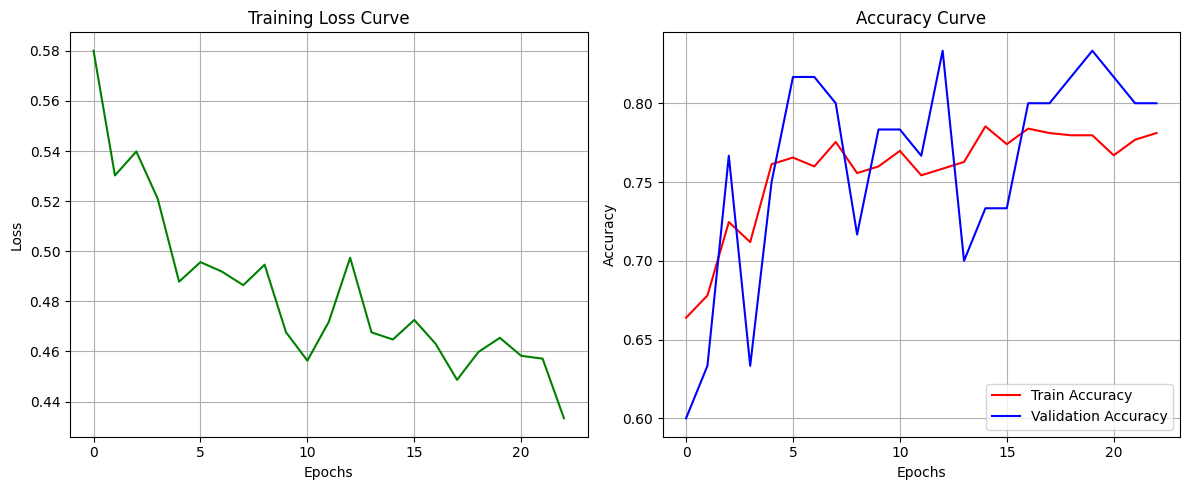

In [21]:
his = [float(c) for c in cost_history]
tr = [float(t) for t in trac]
va = [float(v) for v in valac]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Training Loss
ax1.plot(his, color='green')
ax1.set_title("Training Loss Curve")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot 2: Train vs Validation Accuracy
ax2.plot(tr, label="Train Accuracy", color='red')
ax2.plot(va, label="Validation Accuracy", color='blue')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Lets try to predict!

"""Input: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age --> Output:Diabetes (1) or No Diabetes (0)"""

# Example input for prediction
input_data = np.array([[2, 120, 70, 35, 0, 30.0, 0.627, 50]])
input_data = standard_scaler(input_data, m, s)  # Standardize the input data
input_data = input_data.T  # Transpose to match the input shape
# Predicting using the trained model
y_pred, _ = feed_forward(input_data, training=False)
# Display the prediction
print("Predicted Probability of Diabetes:", y_pred[0][0])

Predicted Probability of Diabetes: 0.0


In [30]:
# Evaluating model metrics

X_val = np.array(data.iloc[708:, 0:8].values.tolist())
Y_val = np.array(data.iloc[708:, -1]).reshape(1, -1)
m,s = scaling_stats(X_val)  # Compute the mean and standard deviation of the validation data
X_val = standard_scaler(X=X_val, mean=m, std=s)  # Standardize the validation data

A0_val, Y_val_prepped, m_val = prepare_data(X_val, Y_val)
y_val_pred, _ = feed_forward(A0_val, training=False)
y_labels = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary labels


y_true = [float(i) for i in Y_val_prepped[0]]
y_true_labels = [float(i) for i in y_labels[0]]

# Using confusion matrix and classification report for evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_true_labels))

print("\nClassification Report:")
print(classification_report(y_true, y_true_labels, digits=4))


Confusion Matrix:
[[34  2]
 [ 8 16]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8095    0.9444    0.8718        36
         1.0     0.8889    0.6667    0.7619        24

    accuracy                         0.8333        60
   macro avg     0.8492    0.8056    0.8168        60
weighted avg     0.8413    0.8333    0.8278        60

